In [1]:
import torch
from torch import nn 
import numpy as np
import gym
import matplotlib.pyplot as plt
import time

In [2]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n, lr=0.01, eps=0.1):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.lr = lr
        self.eps = eps

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 8), 
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 8), 
            nn.ReLU(),
            nn.Linear(8, self.action_n)
        )
        
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, _input):
        return self.network(_input) 
    
    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()

        noise = np.ones(self.action_n) / self.action_n
        action_prob_noised = (1 - self.eps) * action_prob + self.eps * noise
        action_prob_noised = action_prob_noised / np.sum(action_prob_noised)
        # print(f'{action_prob} -> {action_prob_noised}')
        action = np.random.choice(self.action_n, p=action_prob_noised)
        return action
    
    def update_policy(self, elite_states, elite_actions):
        # elite_states = []
        # elite_actions = []
        # for trajectory in elite_trajectories:
        #     elite_states.extend(trajectory['states'])
        #     elite_actions.extend(trajectory['actions'])

        # elite_states = np.array(elite_states)
        # elite_actions = np.array(elite_actions)

        elite_states_tensor = torch.FloatTensor(elite_states)
        elite_actions_tensor = torch.LongTensor(elite_actions)

        loss = self.loss(self.forward(elite_states_tensor), elite_actions_tensor)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [3]:
def get_trajectory(env, agent, trajectory_len, visualize=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}
    
    state = env.reset()
    trajectory['states'].append(state)
    
    for _ in range(trajectory_len):
        
        action = agent.get_action(state)
        trajectory['actions'].append(action)
        
        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        
        if done:
            break
            
        if visualize:
            env.render()
            
        trajectory['states'].append(state)

    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param) 
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [4]:
def generate_batch(env, agent, batch_size, trajectory_len):
    batch_states, batch_actions, batch_rewards = [], [], []

    for i in range(batch_size):
        states, actions = [], []
        total_reward = 0

        state = env.reset()
        for j in range(trajectory_len):
            action = agent.get_action(state)
            new_state, reward, done, _ = env.step(action)
            states.append(state)
            actions.append(action)
            total_reward += reward
            state = new_state
            
            if done:
                batch_actions.append(actions)
                batch_states.append(states)
                batch_rewards.append(total_reward)
                break
    return batch_states, batch_actions, batch_rewards

In [5]:
def get_elite_states(batch_states, batch_actions, batch_rewards, q_param):
    quantile = np.quantile(batch_rewards, q=q_param) 

    elite_states = []
    elite_actions = []
    for i in range(len(batch_rewards)):
        if batch_rewards[i] > quantile:
            for j in range(len(batch_states[i])):
                elite_states.append(batch_states[i][j])
                elite_actions.append(batch_actions[i][j])
    
    return elite_states, elite_actions

In [12]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5)

state_dim = 8
action_n = 4
lr = 1e-2
eps = 0

agent = CEM(state_dim, action_n, lr=lr, eps=eps)
trajectory_n = 500

MAX_ITER = 300
BATCH_SIZE = 100
TRAJECTORY_LEN = 10000
Q = 0.7

In [13]:
epses = []
mean_total_rewards = []

In [14]:
for i in range(MAX_ITER):
    batch_states, batch_actions, batch_rewards = generate_batch(env, agent, BATCH_SIZE, TRAJECTORY_LEN)
    elite_states, elite_actions = get_elite_states(batch_states, batch_actions, batch_rewards, Q)
    
    mean_reward = np.mean(batch_rewards)
    agent.update_policy(elite_states, elite_actions)
    print(f'{i}: mean_reward={mean_reward}')

0: mean_reward=-188.85475628689957
1: mean_reward=-185.51101841856016
2: mean_reward=-169.67336050416748
3: mean_reward=-178.9085628770823
4: mean_reward=-163.67315698615445
5: mean_reward=-147.95193323543447
6: mean_reward=-167.06830670878688
7: mean_reward=-155.89922884705868
8: mean_reward=-167.05172221687315
9: mean_reward=-154.54005444893428
10: mean_reward=-172.95011999200378
11: mean_reward=-156.16215371194653
12: mean_reward=-143.5429560815583
13: mean_reward=-146.44387856070725
14: mean_reward=-151.3229471640076
15: mean_reward=-146.0988329285242
16: mean_reward=-143.27753450708136
17: mean_reward=-144.3701822895255
18: mean_reward=-125.7320450234391
19: mean_reward=-133.3162632944899
20: mean_reward=-127.09153861611144
21: mean_reward=-123.07056420371035
22: mean_reward=-135.99684032748166
23: mean_reward=-123.93593409044772
24: mean_reward=-115.09484460174974
25: mean_reward=-118.25060540583388
26: mean_reward=-117.71697170204891
27: mean_reward=-111.01538372798373
28: mean_

In [ ]:
# total_start = time.time()
# for episode in range(1, episode_n + 1):
#     agent.eps = np.sqrt(1 / episode)

#     # start = time.time()
#     trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]
    
#     mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])
#     mean_total_rewards.append(mean_total_reward)
#     print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')
    
#     elite_trajectories = get_elite_trajectories(trajectories, q_param)
    
#     if len(elite_trajectories) > 0:
#         agent.update_policy(elite_trajectories)

#     # print('iteration_time: ', time.time() - start)
# # get_trajectory(env, agent, trajectory_len, visualize=True)
# print('total time', time.time() - total_start)

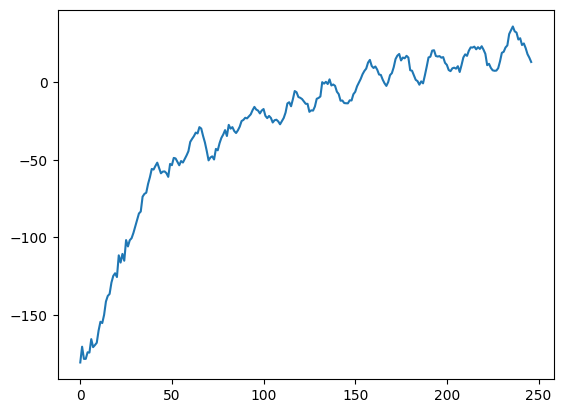

In [ ]:
plt.plot(mean_total_rewards)

In [ ]:
max(mean_total_rewards)

35.62716373860806

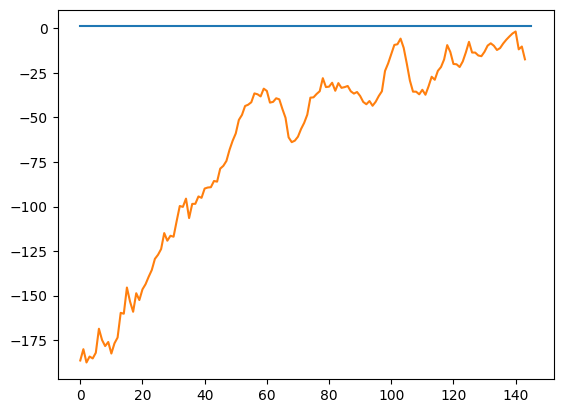

In [ ]:
fig, ax = plt.subplots()
ax.plot(mean_total_rewards)